# Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![LIGO](LIGO.jpg)

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as Malmquist bias and was first formulated in 1922.

**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**

This dataset contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the .h5 format is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with ``h5py`.

In particular, each source has the following features:

- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the snr (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in the gravitational-wave class; see here for a nice write-up. All you need to know now is that we threshold the snr values and assume that LIGO will (not) see a source if snr>12 (snr<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't.

Be creative! This is a challenge! Let's see who gets the higher completeness and/or the smaller contamination (on a validation set, of course, careful with overfitting here).

*Tips*:

- You can downsample the data for debugging purposes
- You can also use only some of the features.
- Plot ROC curves

**Another idea**

Here are other ideas that I haven't explored in a paper (yet?).

Using the same data, we could run a regressor on snr instead of a classifier on det. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find!

**Other ideas (optional)**

- Using the same data, we could run a regressor on snr instead of a classifier on det. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?
- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

## Dataset

In [2]:
# Import data
InFileName = "sample_2e7_design_precessing_higherordermodes_3detectors.h5"

data = {}
n = 200000
with h5py.File(InFileName, "r") as InFile:
    keys = ['mtot', 'q', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'ra', 'dec', 'iota', 'psi', 'z', 'snr', 'det']
    for key in keys: 
        data[key] = InFile[key][:n]

df = pd.DataFrame(data)
X = df.drop(columns=['det', 'snr'])
y = df['det']

In [3]:
# Check
counts = np.bincount(y)
total = len(y)

print(f"Not detected (0): {counts[0]} ({counts[0] / total * 100:.1f}%)")
print(f"Detected (1): {counts[1]} ({counts[1] / total * 100:.1f}%)")

Not detected (0): 171127 (85.6%)
Detected (1): 28873 (14.4%)


At least, with this progrqamme I have to do better than $85.6\%$

## Classification Analysis

I will use Decision Tree and Random Forest classifiers.

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Decision Tree Classifier

In [5]:
clf_dtree = DecisionTreeClassifier(random_state=42)

In [6]:
# Cross-Validation
d_range = np.arange(1, 21)
grid = GridSearchCV(clf_dtree, param_grid={'max_depth': d_range}, cv=5, verbose=1)
grid.fit(X_train, y_train)

best_depht = grid.best_params_['max_depth']
print(f"Best max_depth: {best_depht}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best max_depth: 9


In [7]:
# Classification
best_tree = DecisionTreeClassifier(max_depth=best_depht, random_state=42, criterion='entropy')
best_tree.fit(X_train, y_train)

y_pred_dtree = best_tree.predict(X_test)
y_prob_dtree = best_tree.predict_proba(X_test)[:, 1]

ROC AUC: 0.983


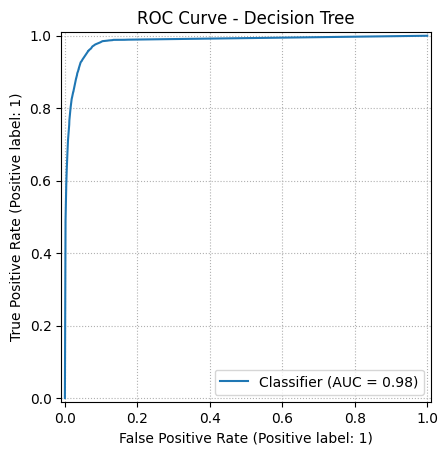

In [8]:
# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_dtree):.3f}")

RocCurveDisplay.from_predictions(y_test, y_prob_dtree)
plt.title("ROC Curve - Decision Tree")
plt.grid(linestyle=':')
plt.show()

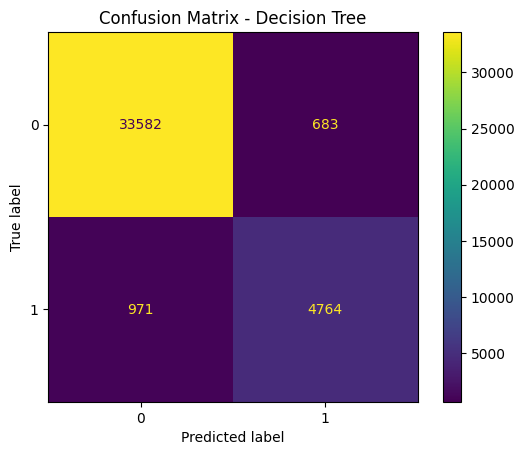

In [9]:
# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_pred_dtree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp_tree.plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()

In [10]:
# Accuracy
acc_dtree = accuracy_score(y_test, y_pred_dtree)
print(f"Accuracy Decision Tree: {acc_dtree:.3f}")

# Completeness and Contamination
tn_tree, fp_tree, fn_tree, tp_tree = cm_tree.ravel()
completeness_dtree = tp_tree / (tp_tree + fn_tree)
contamination_dtree = fp_tree / (tp_tree + fp_tree)
print(f"Completeness Decision Tree: {completeness_dtree:.3f}")
print(f"Contamination Decision Tree: {contamination_dtree:.3f}")

Accuracy Decision Tree: 0.959
Completeness Decision Tree: 0.831
Contamination Decision Tree: 0.125


### Random Forest Classifier

In [11]:
clf_rf = RandomForestClassifier(random_state=42)

In [ ]:
# Cross-Validation
d_range = np.arange(1, 30)
grid = GridSearchCV(clf_rf, param_grid={'max_depth': d_range}, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_depht = grid.best_params_['max_depth']
print(f"Best max_depth: {best_depht}")

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Best max_depth: 27


In [13]:
# Classification
clf_rf = RandomForestClassifier(max_depth=best_depht, random_state=42)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]

ROC AUC: 0.993


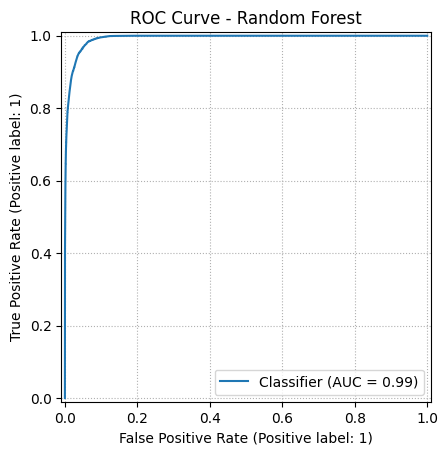

In [14]:
# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.3f}")

RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title("ROC Curve - Random Forest")
plt.grid(linestyle=':')
plt.show()

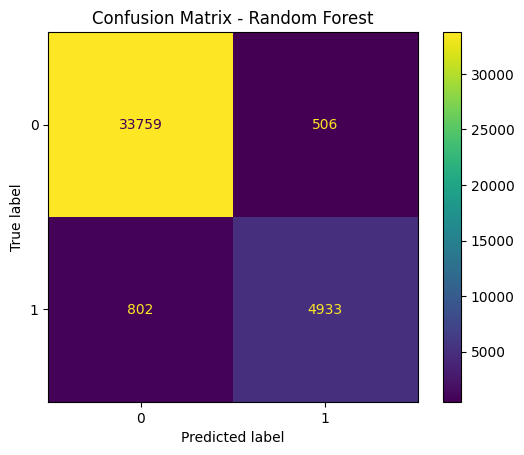

In [15]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [16]:
# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Random Forest: {acc_rf:.3f}")

# Completeness and Contamination
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
completeness_rf = tp_rf / (tp_rf + fn_rf)
contamination_rf = fp_rf / (tp_rf + fp_rf)
print(f"Completeness Random Forest: {completeness_rf:.3f}")
print(f"Contamination Random Forest: {contamination_rf:.3f}")

Accuracy Random Forest: 0.967
Completeness Random Forest: 0.860
Contamination Random Forest: 0.093


The values of accuracy, completeness with the Random Forests classifier are both higer than with the Decision Tree, while the contamination is lower. This means that Random Forests provides a better classification than Decision Tree. 

## Dimensionality Reduction with PCA before Classification

In the first classification analysis the Random Forest method provides a better classification than the Decision Tree. So, in this part I will test only the Random Forest Classifier.

In [37]:
# Dimensionality Reduction
pca = PCA(n_components=0.9) # keep 90% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original number of features:", X_train.shape[1])
print("Reduced number of features after PCA:", X_train_pca.shape[1])

Original number of features: 13
Reduced number of features after PCA: 12


In [38]:
# Random Forest Classifier
rf_pca = RandomForestClassifier(random_state=42)

In [39]:
# Cross-Validation
depth = np.arange(1, 30)
grid_pca = GridSearchCV(rf_pca, param_grid={'max_depth': depth}, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_pca.fit(X_train_pca, y_train)

best_rf_pca = grid_pca.best_params_['max_depth']
print(f"Best max_depth: {best_rf_pca}")

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Best max_depth: 24


In [40]:
# Classification
clf_rf = RandomForestClassifier(max_depth=best_rf_pca, random_state=42)
clf_rf.fit(X_train_pca, y_train)

y_pred_rf_pca = clf_rf.predict(X_test_pca)
y_prob_rf_pca = clf_rf.predict_proba(X_test_pca)[:, 1]

ROC AUC: 0.967


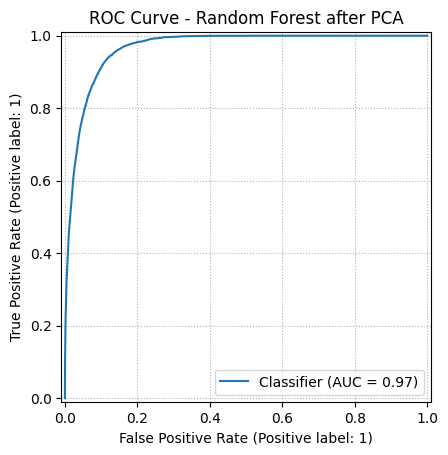

In [41]:
# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf_pca):.3f}")

RocCurveDisplay.from_predictions(y_test, y_prob_rf_pca)
plt.title("ROC Curve - Random Forest after PCA")
plt.grid(linestyle=':')
plt.show()

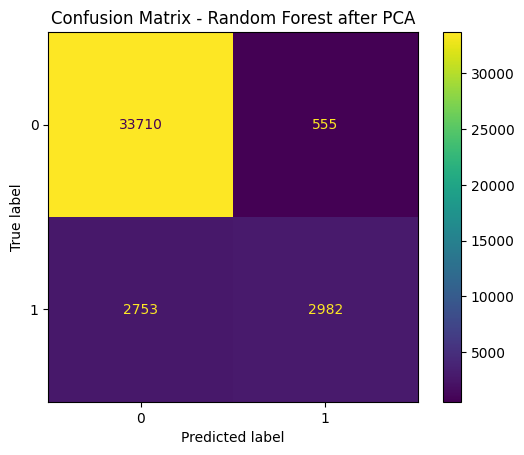

In [42]:
# Confusion Matrix
cm_rf_pca = confusion_matrix(y_test, y_pred_rf_pca)
disp_rf_pca = ConfusionMatrixDisplay(confusion_matrix=cm_rf_pca)
disp_rf_pca.plot()
plt.title("Confusion Matrix - Random Forest after PCA")
plt.show()

In [43]:
# Accuracy
acc_rf_pca = accuracy_score(y_test, y_pred_rf_pca)
print(f"Accuracy Random Forest after PCA: {acc_rf_pca:.3f}")

# Completeness and Contamination
tn_rf_pca, fp_rf_pca, fn_rf_pca, tp_rf_pca = cm_rf_pca.ravel()
completeness_rf_pca = tp_rf_pca / (tp_rf_pca + fn_rf_pca)
contamination_rf_pca = fp_rf_pca / (tp_rf_pca + fp_rf_pca)
print(f"Completeness Random Forest after PCA: {completeness_rf_pca:.3f}")
print(f"Contamination Random Forest after PCA: {contamination_rf_pca:.3f}")

Accuracy Random Forest after PCA: 0.917
Completeness Random Forest after PCA: 0.520
Contamination Random Forest after PCA: 0.157


Apply the PCA before performing classification takes to have a worse results than both the classifier algorithm applied on the data withou PCA.

## Regression in `snr`

In [5]:
y = df['snr']
X_train_snr, X_test_snr, y_train_snr, y_test_snr = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Random Forest Regressor
reg_rf = RandomForestRegressor(random_state=42, n_estimators=20)

In [14]:
# Cross-Validation
depth = np.arange(1, 30)
grid = GridSearchCV(reg_rf, param_grid={'max_depth': depth}, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid.fit(X_train_snr, y_train_snr)

best_depht = grid.best_params_['max_depth']
print(f"Best max_depth: {best_depht}")

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Best max_depth: 9


In [15]:
# Regression
best_reg_rf = RandomForestRegressor(max_depth= best_depht, n_estimators=100, random_state=42, n_jobs=-1)
best_reg_rf.fit(X_train_snr, y_train_snr)

y_pred_snr = best_reg_rf.predict(X_test_snr)

In [16]:
det_pred = (y_pred_snr >= 12).astype(int)
det_test_snr = (y_test_snr >= 12).astype(int)

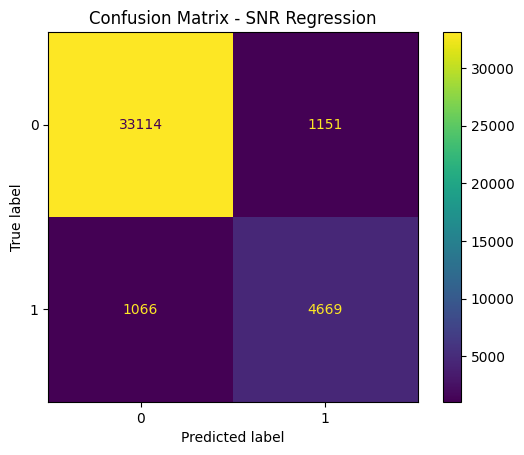

In [17]:
# Confusion Matrix
cm_snr = confusion_matrix(det_test_snr, det_pred)
disp_snr = ConfusionMatrixDisplay(confusion_matrix=cm_snr)
disp_snr.plot()
plt.title("Confusion Matrix - SNR Regression")
plt.show()

In [18]:
# Accurcy
acc_snr = accuracy_score(det_test_snr, det_pred)
print(f"Accuracy SNR Regression: {acc_snr:.3f}")

# Completeness and Contamination
tn_snr, fp_snr, fn_snr, tp_snr = cm_snr.ravel()
completeness_snr = tp_snr / (tp_snr + fn_snr)
contamination_snr = fp_snr / (tp_snr + fp_snr)
print(f"Completeness SNR Regression: {completeness_snr:.3f}")
print(f"Contamination SNR Regression: {contamination_snr:.3f}")

Accuracy SNR Regression: 0.945
Completeness SNR Regression: 0.814
Contamination SNR Regression: 0.198


The values of accuracy and completeness are a little bit lower than the values obtain with the classification, while the contamination resutls to be higher. This means that the regression obtains a worse result than classification in dividing detectable and undetectable signals. Moreover, the regression requires an higher computational cost than classification.